## SCORING VASILIY GORELOV


## KAGGLE PUBLIC SCORE - 0.86302 (3 place)
## KAGGLE PRIVATE SCORE - 0.86905 (3 place)

 Задача кредитного скоринга - одна из наиболее популярных областей, где применяются алгоритмы машинного обучения. Программа скоринга разрабатывается риск-менеджерами банка на основе большого количества данных о возврате/невозврате кредитов физических лиц.

 В этой задаче вам даны исторические данные: набор из 10 признаков по заявкам на кредит. Для каждой заявки известно, была ли допущена просрочка по выплате кредита (target=1), или займ был возвращен вовремя (target=0).

In [133]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold,  GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, classification_report
import itertools
import sklearn
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


import statistics as stat
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
import datetime as dt
import requests
import plotly.offline as pyo
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'

# load the data

In [52]:
train = pd.read_csv('data/X_train.csv')
test = pd.read_csv('data/X_test.csv')
overdue = pd.read_csv('data/y_train.csv')

#  Generate features

Били сгенерированы новые признаки:

                                   1)имеется ли информация по количеству человек в семье


                                   2)имеется ли информация по доходу
                                   
Эти два признака были введены из-за того, что в одноименных колонках есть пропуски этой информации. Итоговый ответ может частично зависеть от отсутствия этой информации.

                                   3)Был создан категориальный признак возрастной группы.


In [53]:
class FeaturesTransform(BaseEstimator):
    def __intit__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, df):
        df['has_income_info'] = pd.isnull(df.monthly_income) * 1
        df['has_family_info'] = pd.isnull(df.family_members) * 1
        df['family_members'] = df['family_members'].fillna(0)
        df['monthly_income'] = df['monthly_income'].fillna(0)
        def age_group(x):
            if x in range(17, 36):
                return 'young_adult'
            elif x in range(36, 55):
                return 'middle_adult'
            else:
                return 'old_adult'
        df['age_group'] = df['age'].apply(age_group)
        df = pd.get_dummies(df)
        df_new = df.reindex(columns=['credit_card_utilization', 'age', 'overdue_30_59_days', 'debt_to_income', 'monthly_income',
                                    'monthly_income', 'credits_loans', 'overdue__more_than_90_days', 'mortgage_loans',
                                    'overdue_60_89_days', 'family_members'])
        return df
features_transform = FeaturesTransform()

train_features = features_transform.transform(train)
test_features = features_transform.transform(test)

# Correlations

# После проверки корелляций я решил не убирать признаки. После проверки выбросов также было принято решение оставить все данные, не обрабатывая выбросы.

<AxesSubplot: >

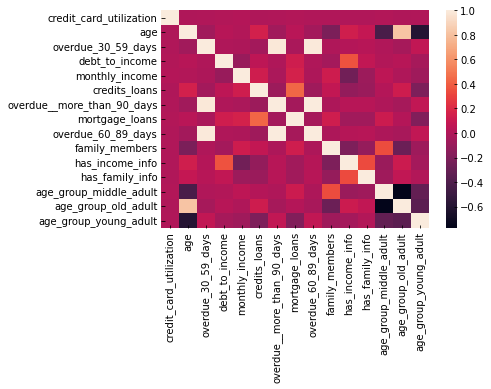

In [23]:
sns.heatmap(train_features.corr())

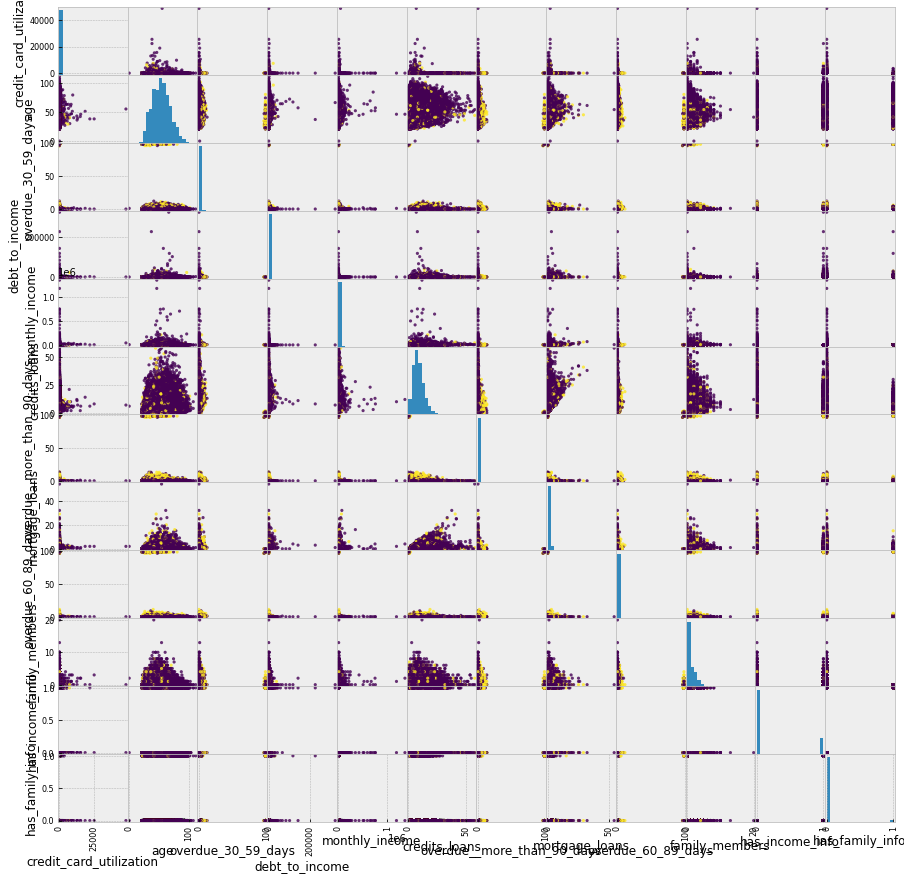

In [25]:
pd.plotting.scatter_matrix(train, c=overdue['target'], figsize=(15, 15), marker='o',
                        hist_kwds={'bins': 20}, s=10, alpha=.8)
None

## MODELS

# Большая работа была проведена для того, чтобы обучить модели на несбалансированных данных. Сгенерированные данные плохо себя показали, поэтому я решил использовать встроенные параметры веса классов в классификации.

# LOGISTIC REGRESSION

# roc_auc сильно зависел от веса классов. Это вызвано несбалансированностью двух классов в данных.

In [54]:
model_lr = LogisticRegression(max_iter=600)
cv = StratifiedKFold(shuffle=True, n_splits = 10)
params_lr = {'C': np.logspace(-7, 0, 10), 'class_weight': [{0:1, 1:k} for k in range(1, 30, 5)]}

In [55]:
GS_LR = GridSearchCV(estimator = model_lr, param_grid=params_lr, cv=cv, scoring='roc_auc')

In [57]:
GS_LR.fit(X=train_features, y = overdue['target'])

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=LogisticRegression(max_iter=600),
             param_grid={'C': array([1.00000000e-07, 5.99484250e-07, 3.59381366e-06, 2.15443469e-05,
       1.29154967e-04, 7.74263683e-04, 4.64158883e-03, 2.78255940e-02,
       1.66810054e-01, 1.00000000e+00]),
                         'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 6},
                                          {0: 1, 1: 11}, {0: 1, 1: 16},
                                          {0: 1, 1: 21}, {0: 1, 1: 26}]},
             scoring='roc_auc')

In [58]:
GS_LR.best_score_

0.8046420510867414

In [59]:
GS_LR.best_params_

{'C': 0.004641588833612782, 'class_weight': {0: 1, 1: 26}}

# SCALING

In [60]:
train_features_scale= train_features.copy()
test_features_scale = test_features.copy()

In [61]:
scaler = StandardScaler()

In [62]:
train_features_scale = scaler.fit_transform(train_features_scale)

# LOGISTIC REGRESSION WITH SCALING

In [63]:
model_lrs = LogisticRegression(max_iter=600)

params_lrs = {'C': np.logspace(-7, 0, 10), 'class_weight': [{0:1, 1:k} for k in range(1, 60, 5)]}
GS_LR_S = GridSearchCV(estimator = model_lrs, param_grid=params_lrs, cv=cv, scoring='roc_auc')

In [64]:
GS_LR_S.fit(X=train_features_scale, y = overdue['target'])

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=LogisticRegression(max_iter=600),
             param_grid={'C': array([1.00000000e-07, 5.99484250e-07, 3.59381366e-06, 2.15443469e-05,
       1.29154967e-04, 7.74263683e-04, 4.64158883e-03, 2.78255940e-02,
       1.66810054e-01, 1.00000000e+00]),
                         'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 6},
                                          {0: 1, 1: 11}, {0: 1, 1: 16},
                                          {0: 1, 1: 21}, {0: 1, 1: 26},
                                          {0: 1, 1: 31}, {0: 1, 1: 36},
                                          {0: 1, 1: 41}, {0: 1, 1: 46},
                                          {0: 1, 1: 51}, {0: 1, 1: 56}]},
             scoring='roc_auc')

In [65]:
GS_LR_S.best_score_

0.8035521712390263

In [66]:
GS_LR_S.best_params_

{'C': 1.0, 'class_weight': {0: 1, 1: 56}}

## KNN WITH SCALING

# knn, как метрическая модель, лучше себя показывает на нормализованных данных

In [73]:
model_knn = KNeighborsClassifier()

params_knns = {'n_neighbors': [20]}#params_knns = {'n_neighbors': range(1, 100, 15), 'class_weight': [{0:1, 1:k} for k in range(1, 30, 5)]}

GS_kNN_s = GridSearchCV(cv =cv, estimator = model_knn, param_grid = params_knns, scoring='roc_auc')

In [74]:
GS_kNN_s.fit(X=train_features_scale, y = overdue['target'])

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=KNeighborsClassifier(), param_grid={'n_neighbors': [20]},
             scoring='roc_auc')

In [75]:
GS_kNN_s.best_score_

0.7399034351031016

In [76]:
GS_kNN_s.best_params_

{'n_neighbors': 20}

## TREE

# Вес классов не давал никаких результатов для DTC

In [82]:
model_dtc = DecisionTreeClassifier(min_samples_split=4)
params_dtc = {'n_estimators': range(250, 501, 50),
            'min_samples_leaf': range(5, 31, 5),
            'class_weight': [None, 'balanced']
            }


"params_dtc = {'n_estimators': range(250, 501, 50),\n            'min_samples_leaf': range(5, 31, 5),\n            'class_weight': [None, 'balanced']\n            }"

In [83]:
GS_dtc = GridSearchCV(estimator=model_dtc, param_grid=params_dtc, cv = cv, scoring='roc_auc')

In [84]:
GS_dtc.fit(X=train_features_scale, y = overdue['target'])

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=DecisionTreeClassifier(min_samples_split=4),
             param_grid={'class_weight': [None, 'balanced'],
                         'min_samples_leaf': [17]},
             scoring='roc_auc')

In [85]:
GS_dtc.best_score_

0.7706894376289035

In [86]:
GS_dtc.best_params_

{'class_weight': None, 'min_samples_leaf': 17}

# RANDOM FOREST

In [87]:
grid_rfc = {'n_estimators': [800, 1000],
             'min_samples_split': [10, 20, 100],
            'min_samples_leaf': [50],
            'max_features': [5, 7]
            }

rfc = RandomForestClassifier()

GS_RFC = GridSearchCV(rfc, param_grid=grid_rfc, scoring='roc_auc', cv=5, verbose=3)

In [ ]:
GS_RFC.fit(X=train_features_scale, y = overdue['target'])

In [89]:
GS_RFC.best_score_

0.8624893012890883

In [90]:
GS_RFC.best_params_

{'max_features': 5,
 'min_samples_leaf': 50,
 'min_samples_split': 20,
 'n_estimators': 800}

# XGBOOST

# В этой модели, как и в следующих, вес классов тоже не давал никакого роста метрики auc-roc


In [91]:
model_xgboost = XGBClassifier(objective='binary:logistic', nthread = 4, seed = 60, gpu_id = 0, tree_method = 'gpu_hist')

In [92]:
params_xgb = {    
              'learning_rate':[0.05],
    'max_depth'    :[1,5,10],
    'min_child_weight':[1,5,7],
    'colsample_bytree':[0.3,0.5,0.7],
    'gamma':[0.5],
    'scale_pos_weight':[1, 20]
}

"params_xgb = {    \n              'learning_rate':[0.05],\n    'max_depth'    :[1,5,10],\n    'min_child_weight':[1,5,7],\n    'colsample_bytree':[0.3,0.5,0.7],\n    'gamma':[0.5],\n    'scale_pos_weight':[1, 20]\n}"

In [93]:
GS_xgboost_3 = GridSearchCV(cv =cv, estimator = model_xgboost, param_grid = params_xgb, scoring='roc_auc')

In [94]:
GS_xgboost_3.fit(X = train_features, y = overdue['target'])

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=0, grow_policy=None,
                                     importance_type=None,
                                     interaction_...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None, ...),
             param_grid={'colsample_bytree': [0.3], 'gamma': [0.5],
                         'learning_rate': [0.05], 'max_depth': [5],
                         'min_child_weight': [5], 'scale_pos_weight': [1]},
             scoring='roc_auc')

In [95]:
GS_xgboost_3.best_score_

0.8627913390472131

In [96]:
GS_xgboost_3.best_params_

{'colsample_bytree': 0.3,
 'gamma': 0.5,
 'learning_rate': 0.05,
 'max_depth': 5,
 'min_child_weight': 5,
 'scale_pos_weight': 1}

## CATBOOST

In [97]:
model_cat = CatBoostClassifier()

params_cat = {'learning_rate': [0.03],
        'depth': [4, 5, 7],
        'l2_leaf_reg': [7, 10],
         'scale_pos_weight':[1, 10]}

GS_cat = GridSearchCV(cv =cv, estimator = model_cat, param_grid = params_cat, scoring='roc_auc')

In [ ]:
GS_cat.fit(X = train_features, y = overdue['target'])

In [99]:
GS_cat.best_score_

0.8654301335107595

In [100]:
GS_cat.best_params_

{'depth': 7, 'l2_leaf_reg': 10, 'learning_rate': 0.03, 'scale_pos_weight': 1}

## BLENDING

In [101]:
model_cat = GS_cat.best_estimator_
XGboost_model = GS_xgboost_3.best_estimator_

In [103]:
vc = VotingClassifier([('Cat', model_cat), ('xgb', XGboost_model)], voting='soft')

In [104]:
grid = GridSearchCV(
    estimator=vc,
    param_grid={'weights': [[i, 1-i] for i in np.arange(0, 1.1, 0.1)] },
    cv = cv,
    scoring = 'roc_auc'
)

In [ ]:
grid.fit(X = train_features, y = overdue['target'])

In [145]:
grid.best_score_

0.8656018138133484

In [118]:
grid.best_params_

{'weights': [0.8, 0.19999999999999996]}

# Оценка метрик

# LOGISTIC REGRESSION

In [131]:
x_train, x_val, y_train, y_val = train_test_split(train_features, overdue, test_size = 0.1)

In [142]:
report = classification_report(y_val, GS_LR.best_estimator_.predict(x_val), target_names=['Non-churned', 'Churned'])
print(report)

              precision    recall  f1-score   support

 Non-churned       0.98      0.43      0.59      9791
     Churned       0.10      0.89      0.18       720

    accuracy                           0.46     10511
   macro avg       0.54      0.66      0.39     10511
weighted avg       0.92      0.46      0.57     10511



(0.0, 1.0)

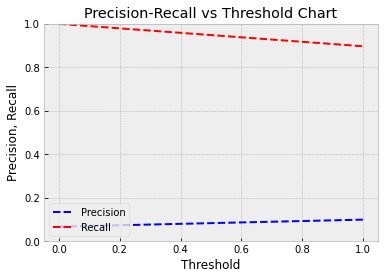

In [122]:
preds = GS_LR.best_estimator_.predict(x_val)

precision, recall, thresholds = precision_recall_curve(y_val, preds) 
pr_auc = sklearn.metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

Confusion matrix, without normalization
[[4069 5734]
 [  73  635]]


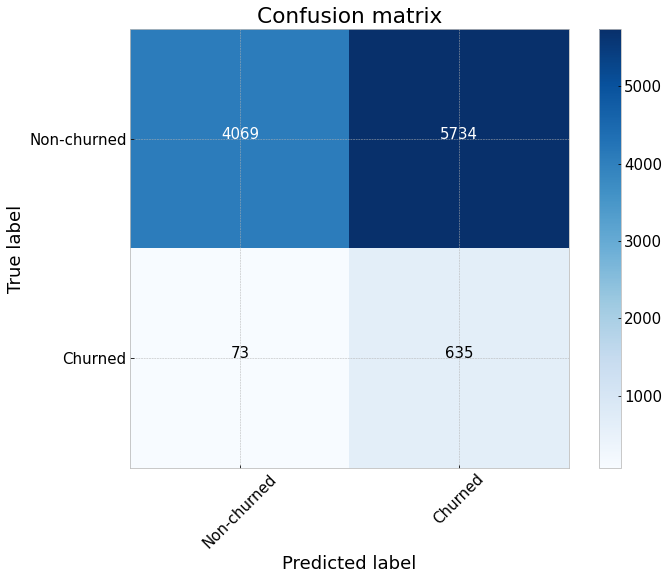

In [123]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_val, preds)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

AUC: 0.814


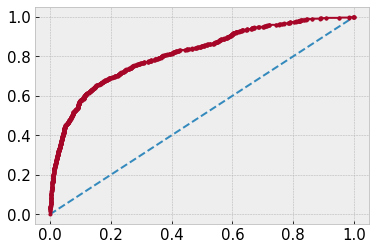

In [129]:
auc = roc_auc_score(y_val, GS_LR.best_estimator_.predict_proba(x_val)[:, 1])
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_val, GS_LR.best_estimator_.predict_proba(x_val)[:, 1])
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

# XGBOOST

In [1]:
!jt -r

Reset css and font defaults in:
C:\Users\vasil\.jupyter\custom &
C:\Users\vasil\AppData\Roaming\jupyter\nbextensions


In [143]:
report = classification_report(y_val, GS_xgboost_3.best_estimator_.predict(x_val), target_names=['Non-churned', 'Churned'])
print(report)

              precision    recall  f1-score   support

 Non-churned       0.94      0.99      0.97      9791
     Churned       0.68      0.17      0.28       720

    accuracy                           0.94     10511
   macro avg       0.81      0.58      0.62     10511
weighted avg       0.92      0.94      0.92     10511



AUC: 0.874


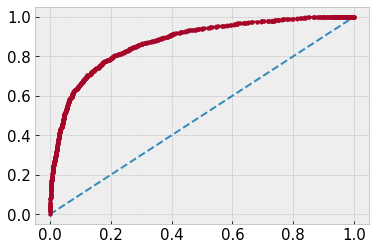

In [137]:
auc = roc_auc_score(y_val, GS_xgboost_3.best_estimator_.predict_proba(x_val)[:, 1])
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_val, GS_xgboost_3.best_estimator_.predict_proba(x_val)[:, 1])
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

# CAT

In [144]:
report = classification_report(y_val, GS_cat.best_estimator_.predict(x_val), target_names=['Non-churned', 'Churned'])
print(report)

              precision    recall  f1-score   support

 Non-churned       0.95      0.99      0.97      9791
     Churned       0.77      0.27      0.40       720

    accuracy                           0.94     10511
   macro avg       0.86      0.63      0.68     10511
weighted avg       0.94      0.94      0.93     10511



AUC: 0.885


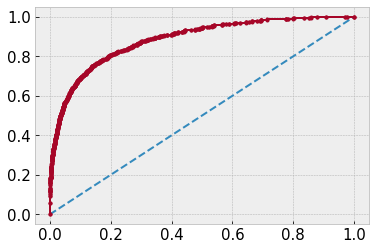

In [138]:
auc = roc_auc_score(y_val, GS_cat.best_estimator_.predict_proba(x_val)[:, 1])
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_val, GS_cat.best_estimator_.predict_proba(x_val)[:, 1])
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()